#Import

In [175]:
import pandas as pd
import numpy as np
from google.colab import drive

from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
import joblib
import pickle

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import load_model

In [176]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Menampilkan Data

In [177]:
missing_values = ['8888']

In [178]:
df = pd.read_excel('/content/drive/MyDrive/Dataset/Dataset_Curah_Hujan.xlsx', na_values = missing_values)
df

,Tanggal,RR
0,01-01-2019,NaN
1,02-01-2019,0.0
2,03-01-2019,20.5
3,04-01-2019,2.6
4,05-01-2019,0.9
...,...,...
1699,27-08-2023,0.0
1700,28-08-2023,0.0
1701,29-08-2023,0.0
1702,30-08-2023,0.0


In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1704 entries, 0 to 1703
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Tanggal  1704 non-null   object 
 1   RR       1426 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.8+ KB


In [180]:
df['Tanggal'] = pd.to_datetime(df['Tanggal'], format='%d-%m-%Y')

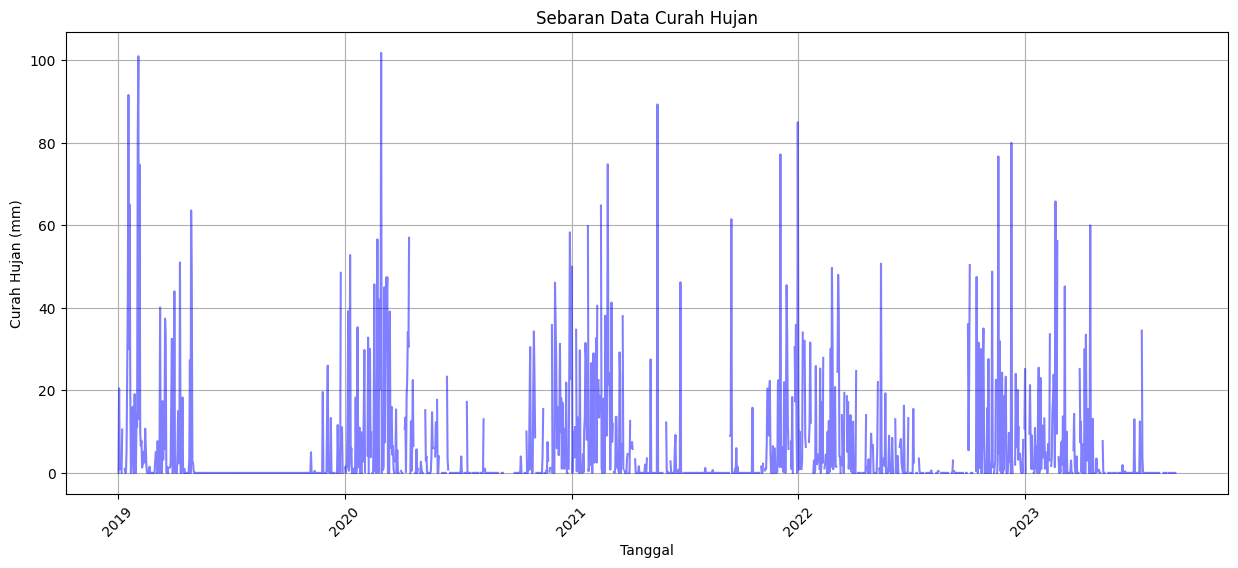

In [181]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df['Tanggal'], df['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

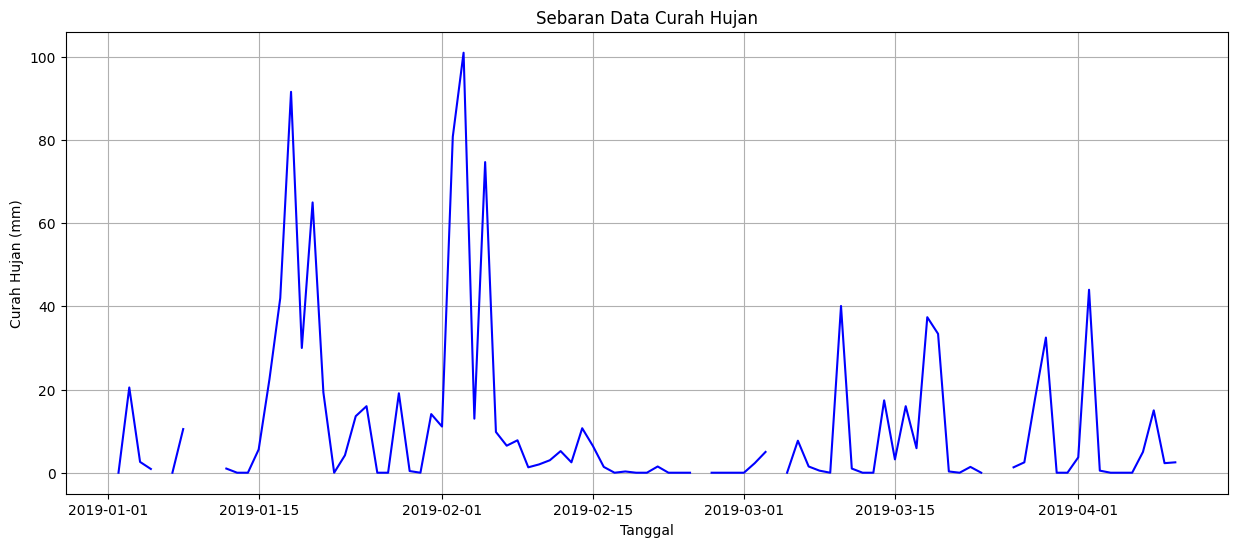

In [182]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df['Tanggal'].head(100), df['RR'].head(100), linestyle='-', color='blue')
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.grid(True)
plt.show()

#Pre-processing Data

In [183]:
df_1 = df.copy()
df_1

,Tanggal,RR
0,2019-01-01,NaN
1,2019-01-02,0.0
2,2019-01-03,20.5
3,2019-01-04,2.6
4,2019-01-05,0.9
...,...,...
1699,2023-08-27,0.0
1700,2023-08-28,0.0
1701,2023-08-29,0.0
1702,2023-08-30,0.0


##Penanganan Missing Value

In [184]:
df_1.isnull().sum()

Tanggal      0
RR         278
dtype: int64

In [185]:
df_1 = df_1.dropna()
df_1

,Tanggal,RR
1,2019-01-02,0.0
2,2019-01-03,20.5
3,2019-01-04,2.6
4,2019-01-05,0.9
6,2019-01-07,0.0
...,...,...
1699,2023-08-27,0.0
1700,2023-08-28,0.0
1701,2023-08-29,0.0
1702,2023-08-30,0.0


In [186]:
df_1.isnull().sum()

Tanggal    0
RR         0
dtype: int64

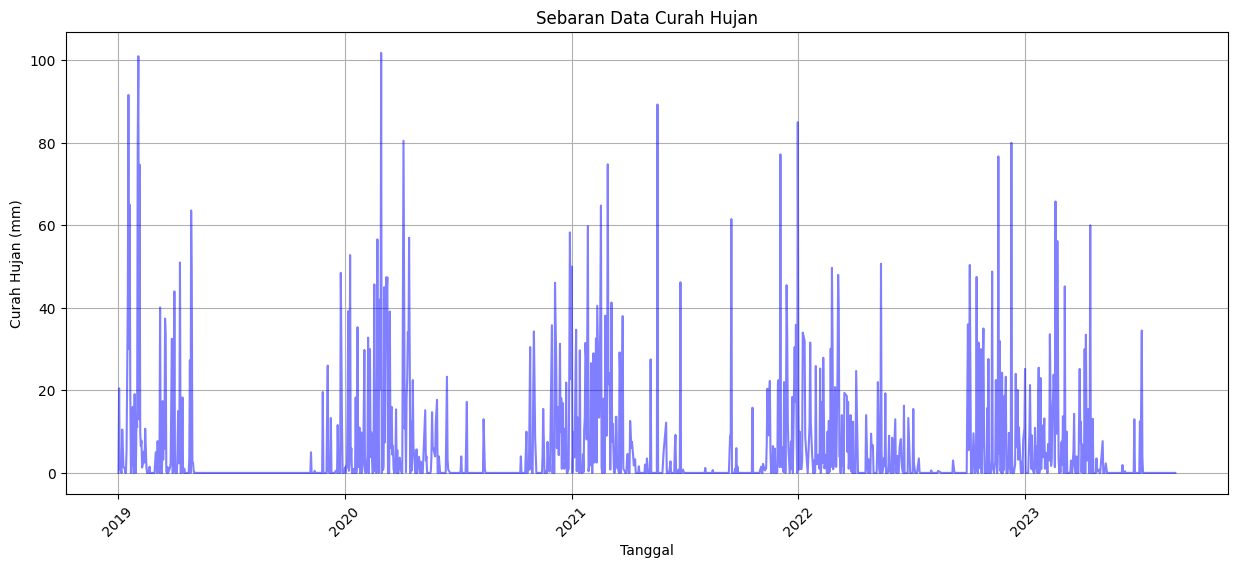

In [187]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df_1['Tanggal'], df_1['RR'], linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

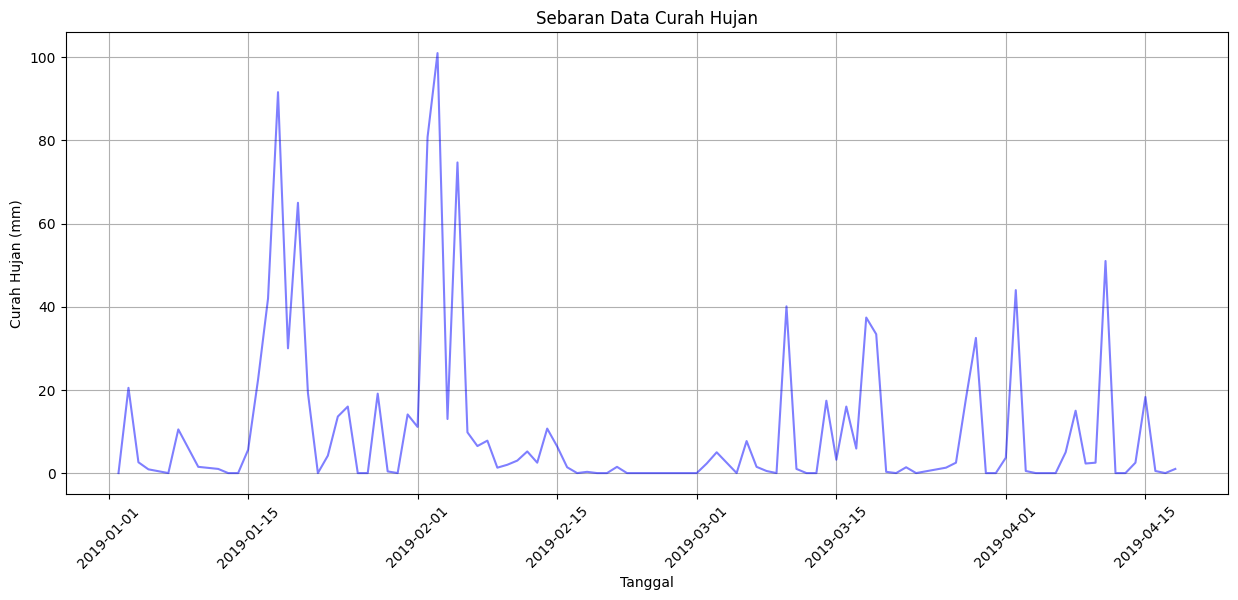

In [188]:
import matplotlib.pyplot as plt


# Plot scatter plot
plt.figure(figsize=(15, 6))
plt.plot(df_1['Tanggal'].head(100), df_1['RR'].head(100), linestyle='-', color='blue', alpha=0.5)
plt.title('Sebaran Data Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

##Menghapus Kolom tanggal

In [189]:
df_2 = df_1.copy().drop(columns=['Tanggal'])
df_2

,RR
1,0.0
2,20.5
3,2.6
4,0.9
6,0.0
...,...
1699,0.0
1700,0.0
1701,0.0
1702,0.0


##Normalisasi Data

In [190]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_2)
scaled_data

array([[0.        ],
       [0.20137525],
       [0.02554028],
       ...,
       [0.        ],
       [0.        ],
       [0.        ]])

##Split Data

In [191]:
values = df_2.values
training_data_len = math.ceil(len(values)* 0.7)
train_data = scaled_data[0: training_data_len , :]

x_train = []
y_train = []

for i in range(25, len(train_data)):
    x_train.append(train_data[i-25:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print(x_train.shape)
print(y_train.shape)

(974, 25, 1)
(974,)


In [192]:
scaled_data.shape

(1426, 1)

In [193]:
test_data = scaled_data[training_data_len-25: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(25, len(test_data)):
  x_test.append(test_data[i-25:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test.shape

(427, 25, 1)

In [194]:
# Menyimpan data train dan data testing
x_train_df = pd.DataFrame({'x_train': x_train.flatten()})
x_train_df.to_csv('x_train_hapusdata_s1.csv', index=False)
y_train_df = pd.DataFrame({'y_train': y_train.flatten()})
y_train_df.to_csv('y_train_hapusdata_s1.csv', index=False)
x_test_df = pd.DataFrame({'x_test': x_test.flatten()})
x_test_df.to_csv('x_test_hapusdata_s1.csv', index=False)
y_test_df = pd.DataFrame({'y_test': y_test.flatten()})
y_test_df.to_csv('y_test_hapus data_s1.csv', index=False)

#Pemodelan

In [195]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.65))
model.add(layers.LSTM(100, return_sequences=False))
model.add(Dropout(0.65))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 25, 100)           40800     
                                                                 
 dropout_12 (Dropout)        (None, 25, 100)           0         
                                                                 
 lstm_13 (LSTM)              (None, 100)               80400     
                                                                 
 dropout_13 (Dropout)        (None, 100)               0         
                                                                 
 dense_12 (Dense)            (None, 25)                2525      
                                                                 
 dense_13 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123751 (483.40 KB)
Trainable params: 123

In [196]:
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size= 32, epochs=12, verbose=1)

Epoch 1/12
31/31 [==============================] - 7s 54ms/step - loss: 0.0244
Epoch 2/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0185
Epoch 3/12
31/31 [==============================] - 1s 43ms/step - loss: 0.0169
Epoch 4/12
31/31 [==============================] - 1s 41ms/step - loss: 0.0170
Epoch 5/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0172
Epoch 6/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0164
Epoch 7/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0163
Epoch 8/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0163
Epoch 9/12
31/31 [==============================] - 2s 69ms/step - loss: 0.0166
Epoch 10/12
31/31 [==============================] - 2s 69ms/step - loss: 0.0162
Epoch 11/12
31/31 [==============================] - 2s 62ms/step - loss: 0.0159
Epoch 12/12
31/31 [==============================] - 1s 42ms/step - loss: 0.0164


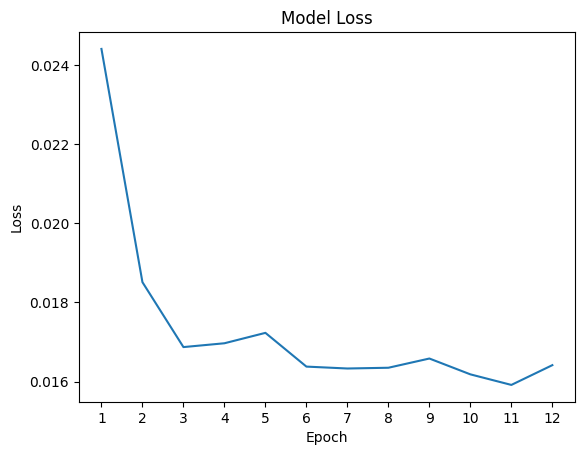

In [197]:
import matplotlib.pyplot as plt


# Plot loss per epoch
epochs = np.arange(1, len(history.history['loss']) + 1)  # Membuat array yang berisi jumlah epoch
plt.plot(epochs, history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.xticks(epochs)  # Mengatur label sumbu x menjadi jumlah epoch
plt.show()

#Evaluasi Model

In [198]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
predictions = predictions.flatten()
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

14/14 [==============================] - 1s 15ms/step


0.21882776354180028

In [199]:
# Membuat DataFrame
data_df = pd.DataFrame({
    'Tanggal': df_1['Tanggal'][999: ].values,
    'Curah_Hujan': df_2['RR'][999: ].values,
    'Prediksi_Curah_Hujan': predictions.flatten()  # Pastikan hasil prediksi memiliki dimensi satu
})
data_df

,Tanggal,Curah_Hujan,Prediksi_Curah_Hujan
0,2022-03-22,17.2,7.493353
1,2022-03-23,1.0,7.589647
2,2022-03-24,3.9,7.034853
3,2022-03-25,3.8,6.477007
4,2022-03-26,14.0,6.050496
...,...,...,...
422,2023-08-27,0.0,3.292211
423,2023-08-28,0.0,3.292211
424,2023-08-29,0.0,3.292211
425,2023-08-30,0.0,3.292211


#Prediksi

In [200]:
n = 1  # Example: Predict the next 10 time steps
future_predictions = []
x_last_window = x_test[-25]  # Menggunakan bagian terakhir dari data testing sebagai x_last_window
last_window = x_last_window.reshape((1, x_last_window.shape[0], x_last_window.shape[1]))

for _ in range(n):
    # Predict the next time step
    prediction = model.predict(last_window)

    # Append the prediction to the list of future predictions
    future_predictions.append(prediction[0])

    # Update the last window by removing the first element and appending the prediction
    last_window = np.append(last_window[:, 1:, :], prediction.reshape(1, 1, 1), axis=1)

# Convert the list of future predictions to a numpy array
future_predictions = np.array(future_predictions)
print('future_predictions : ', future_predictions)

# Inverse transform predictions to get the original scale
future_predictions_denormalisasi = scaler.inverse_transform(future_predictions)
print('future_predictions_denormalisasi : ', future_predictions_denormalisasi)

1/1 [==============================] - 0s 29ms/step
future_predictions :  [[0.03262509]]
future_predictions_denormalisasi :  [[3.3212337]]


<ipython-input-201-65b5182c9f66>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


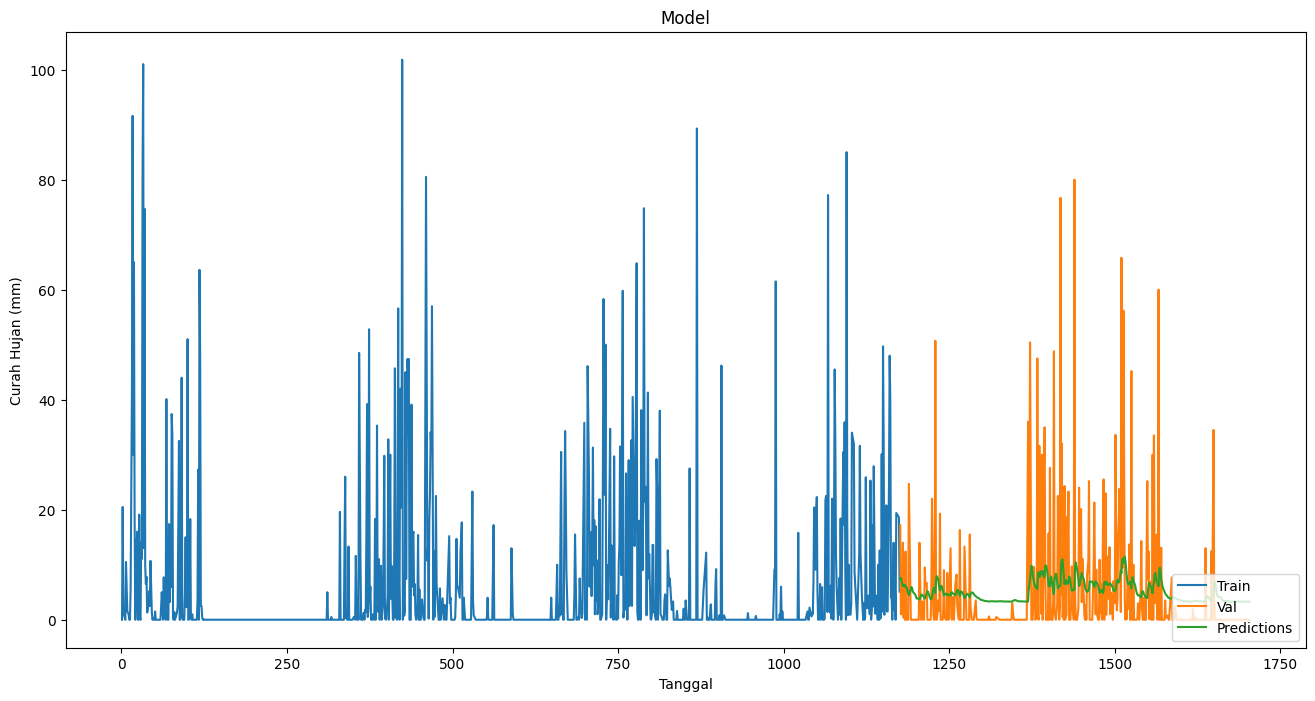

In [201]:
data = df_2.filter(['RR'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.plot(train)
plt.plot(validation[['RR', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

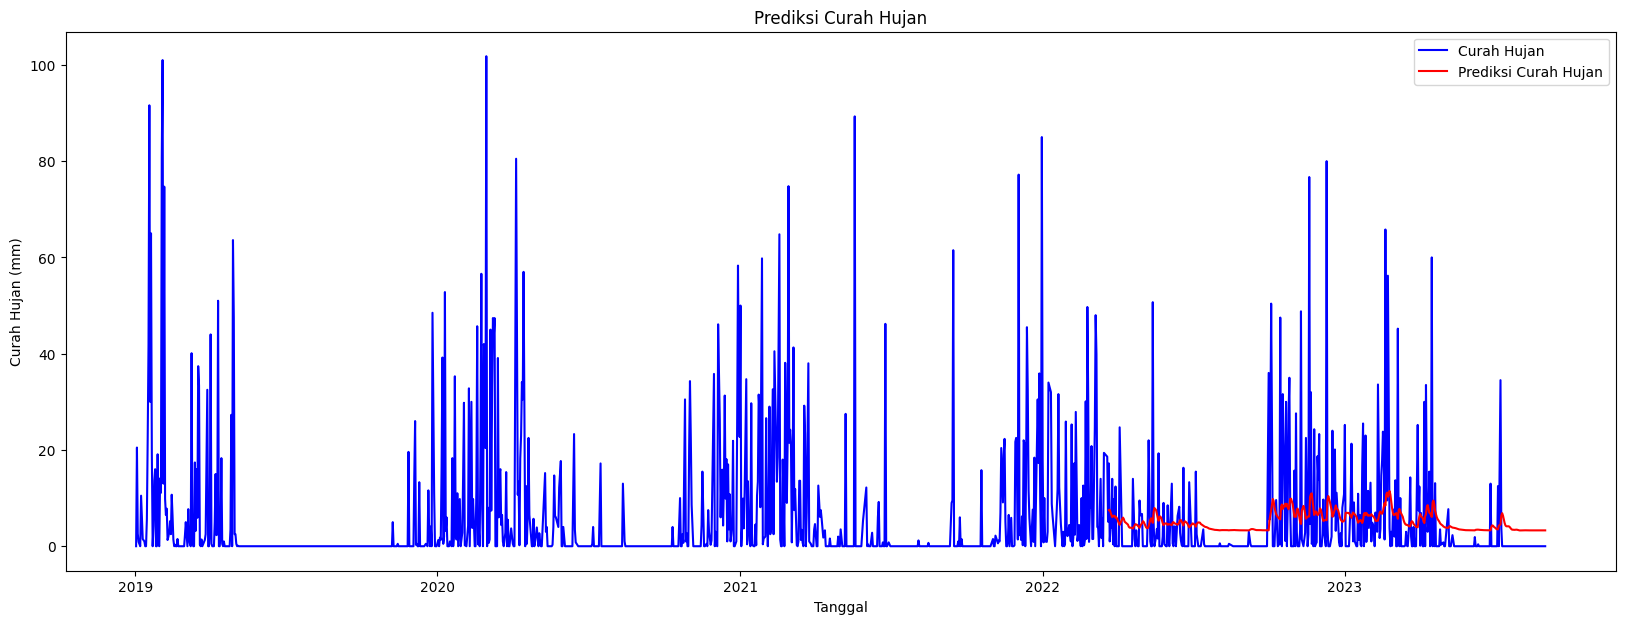

In [202]:
#Memvisualisasikan hasil prediksi
plt.figure(figsize=(20,7))
plt.plot(df_1['Tanggal'].values, values, color = 'blue', label = 'Curah Hujan')
plt.plot(df_1['Tanggal'][-predictions.shape[0]:].values, predictions, color = 'red', label = 'Prediksi Curah Hujan')
plt.title('Prediksi Curah Hujan')
plt.xlabel('Tanggal')
plt.ylabel('Curah Hujan (mm)')
plt.legend()
plt.show()

In [203]:
# Save the model
model.save("model_lstm_hapusdata_s1.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
